In [1]:
#####
# test notebook to make sure simulation functions work
#####

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from simulation_functions import run_all_simulations, calculate_all_pl, simulate_and_calculate_pl
from simulation_parameters import sample_params

In [2]:
def clean_imported_df(df):
    df = df.drop(columns=['Unnamed: 0'])
    df['time'] = pd.to_datetime(df['time'])
    df['date'] = pd.to_datetime(df['date'])
    return df

In [3]:
df = clean_imported_df(pd.read_csv('gas_prices_since_march_2020.csv'))

In [36]:
params = {'upfront_fee': 0,
 'monthly_opened_streams': 500,
 'average_stream_lifetime': 10,
 'percent_accidently_liquidated_per_month': 20,
 'average_stream_size': 1000,
 'liquidator_capital': 20000,
 'upfront_hours': 0,
 'refund_rate': .5,
 'gas_tank_size': 20,
 'max_days_to_return': 7,
 'max_liquidation_wait_time': 24,
 'min_self_liquidation_savings': 0,
 'gas_prediction_ability': 1} # 15 minutes

In [33]:
df = run_all_simulations(df, params)

In [73]:
# df = calculate_all_pl(df, params)

In [22]:
# df = simulate_and_calculate_pl(df, params)

In [38]:
# show UPPER BOUND on incurred cost per stream - does not include any gas prediction or optimization
incurred_cost_per_tx = np.sum(df['gas_tank_eth_pl']) / (np.sum(df['n_self_closed']) + np.sum(df['n_liquidated'])) # in eth
print(incurred_cost_per_tx)

-0.009709644255319455


In [71]:
# show effect of prediciton on gas price paid
refund_rate_to_costs = []
for refund_rate in [.1, .3, .5, .7, .9]:
    params['refund_rate'] = refund_rate
    incurred_cost_per_tx = []
    for pred in np.linspace(0,4, 17):
        params['gas_prediction_ability'] = pred
        df = calculate_all_pl(df, params)
        incurred_cost_per_tx.append(np.sum(df['gas_tank_eth_pl']) / (np.sum(df['n_self_closed']) + np.sum(df['n_liquidated'])))
    refund_rate_to_costs.append(incurred_cost_per_tx)

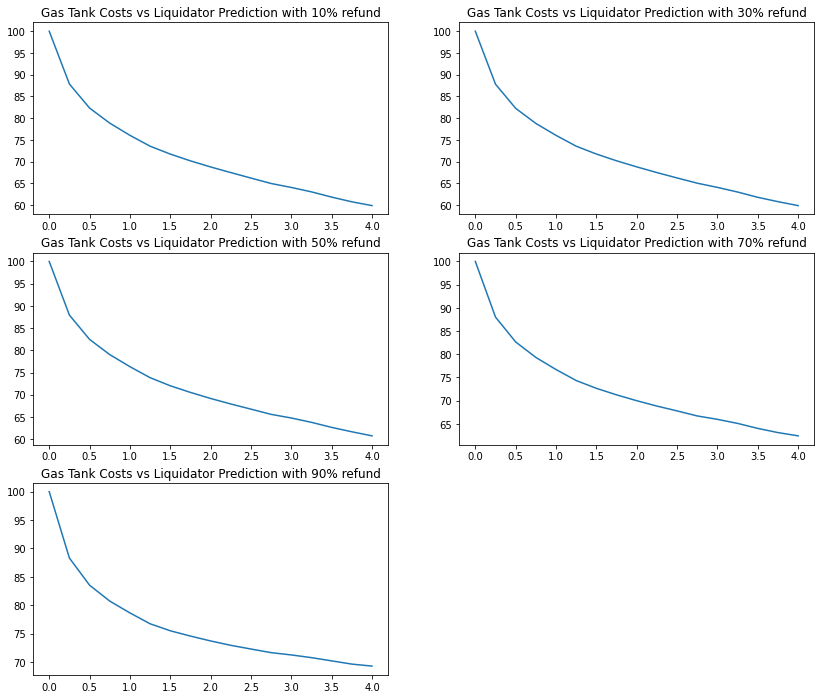

In [70]:
# for each refund rate, show the effect of prediction ability on the slope - want incentives to be aligned
fig, axs = plt.subplots(3,2,figsize=(14,12))
titles = ["Gas Tank Costs vs Liquidator Prediction with {}% refund".format(int(x*100)) for x in [.1, .3, .5, .7, .9]]
for i, ax in enumerate(axs.flat):
    if i == 5:
        ax.axis('off')
        continue
    sns.lineplot(x = np.linspace(0,4, 17), y = refund_rate_to_costs[i] / min(refund_rate_to_costs[i]) * 100, ax=ax) # care about percent reduction
    ax.set_title(titles[i])
    

In [146]:
params = sample_params()
params

{'upfront_fee': 0.02731888578756464,
 'monthly_opened_streams': 711.8650149098004,
 'average_stream_lifetime': 345.24576567095033,
 'percent_accidently_liquidated_per_month': 19.743772505097013,
 'average_stream_size': 3382.064334042882,
 'liquidator_capital': 70884.75001710495,
 'upfront_hours': 12.826773867359982,
 'refund_rate': 0.4110813982102134,
 'gas_tank_size': 60.758639724894834,
 'max_days_to_return': 167.66176325621237,
 'max_liquidation_wait_time': 24.89860139384674,
 'min_self_liquidation_savings': 10.435287576818563,
 'gas_prediction_ability': 2.255246422510166}

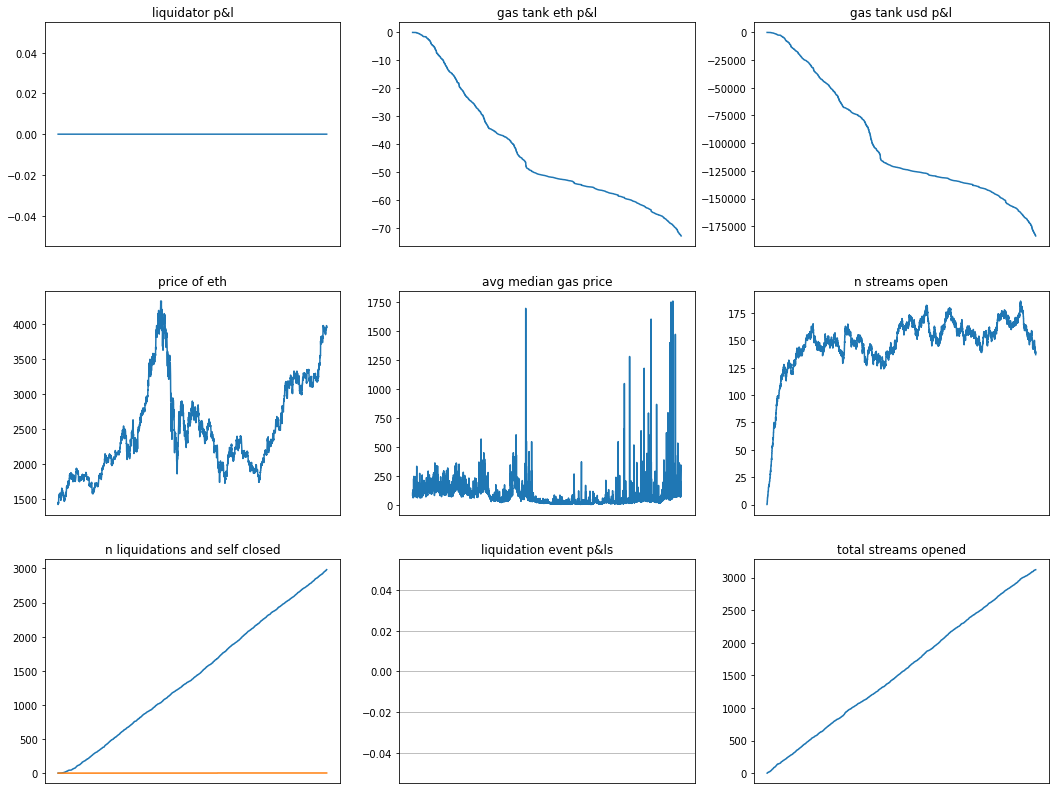

In [15]:
graph_pl(df)

In [5]:
# randomly sample
params = sample_params()
params

{'upfront_fee': 0.06555444232730777,
 'monthly_opened_streams': 334.5799581321131,
 'average_stream_lifetime': 68.44846004289946,
 'percent_accidently_liquidated_per_month': 24.726277546569538,
 'average_stream_size': 7577.01905408745,
 'liquidator_capital': 63636.27010733113,
 'upfront_hours': 17.69324247163116,
 'refund_rate': 0.5169335565972983,
 'gas_tank_size': 174.23771278977333,
 'max_days_to_return': 68.70730373454015,
 'max_liquidation_wait_time': 16.421980163067495,
 'min_self_liquidation_savings': 2.807218438834671}

In [10]:
df = simulate_and_calculate_pl(df, params)

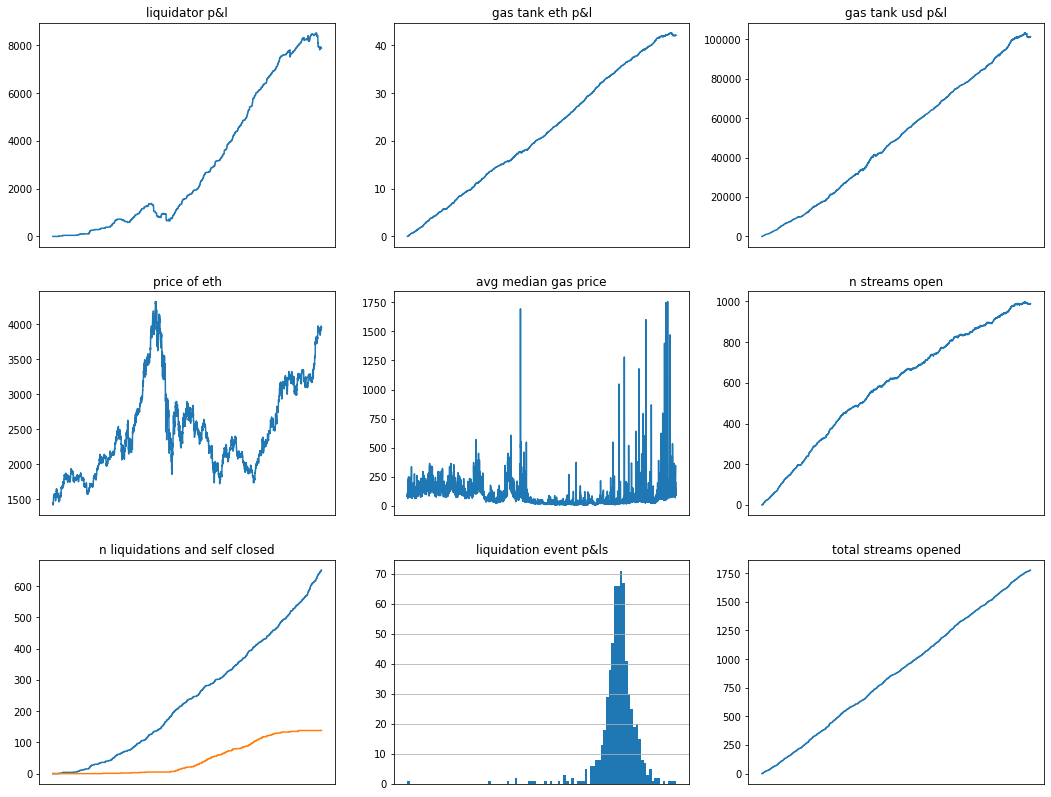

In [11]:
graph_pl(df)

In [14]:
def graph_pl(df):
    fig, axs = plt.subplots(3,3,figsize=(18, 14))
    for i, ax in enumerate(axs.flat):
        if i == 0:
            df['liquidator_pl'].cumsum().plot(ax=ax)
            ax.set_title('liquidator p&l')
        elif i == 1:
            df['gas_tank_eth_pl'].cumsum().plot(ax=ax)
            ax.set_title('gas tank eth p&l')
        elif i == 2:
            df['gas_tank_usd_pl'].cumsum().plot(ax=ax)
            ax.set_title('gas tank usd p&l')
        elif i == 3:
            df['price'].plot(ax=ax)
            ax.set_title('price of eth')
        elif i == 4:
            df['avg_median'].plot(ax=ax)
            ax.set_title('avg median gas price')
        elif i == 5:
            (df['n_opened'].cumsum() - df['n_self_closed'].cumsum() - df['n_liquidated'].cumsum()).plot(ax=ax)
            ax.set_title('n streams open')
        elif i == 6:
            df['n_liquidated'].cumsum().plot(ax=ax)
            ax.set_title('n liquidations and self closed')
            df['n_self_closed'].cumsum().plot(ax=ax)
        elif i == 7:
            df.loc[df['liquidator_pl'] != 0, 'liquidator_pl'].hist(bins=100, ax=ax)
            ax.set_title('liquidation event p&ls')
        elif i == 8:
            df['n_opened'].cumsum().plot(ax=ax)
            ax.set_title('total streams opened')
        ax.set_xticks([])